# Combining Sampling Methods with Attractor Dynamics in Spiking Models of Head-Direction Systems
## by Vojko Pjanovic, Jacob Zavatone-Veth, Paul Masset, Sander Keemink & Michele Nardin. 

Code written by Vojko Pjanovic and Michele Nardin.

This notebook includes the code for Fig. 5.

In [ ]:
To clean up and improve. Check for missing things.

In [1]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [2]:
# initialize parameters and variables
np.random.seed(0)
dt = 0.001
radius = 4
nt=20000
K = 2

r_real = np.zeros([K,nt])
rs = np.zeros([K,nt])

ang=0
r_real[:,0] = r_real[:,1]=r_real[:,2]= np.array([radius*np.cos(ang),radius*np.sin(ang)])

In [ ]:
Nr = 20
beta = np.random.randn(int(Nr/2),1)*10
beta = np.concatenate([beta,-beta]) 

np.random.seed(0)
ang_vel=np.concatenate([[np.random.randn()]*2000 for _ in range(int((nt+1)/2000))])*0.005
ang_vel = ndi.gaussian_filter1d(ang_vel,500,axis=0)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

# subthreshold correlation

In [5]:
N = 16
lam = 10

D = np.array([[np.sin(2*np.pi/N*i),np.cos(2*np.pi/N*i)] for i in range(N)])/4
T = np.diag(D @ D.T) /2

# interactions
O_f = - D @ D.T
O_s = lam * D @ D.T

def DU_xy(s_t,r_new,r_old):
    observation =  -(beta.T@(s_t.T - 1)).T/alpha  * np.flip(D.T @ r_old) * [1,-1]
    ring = - 4 * (D.T @ r_new) * ( r_new @ D @ D.T @ r_new.T - radius**2)
    return  observation + ring

V = np.zeros([N,nt])
V[:,0] = 0.95*T
sigma = np.zeros([N,nt])
r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt
        # sigma[above[0], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

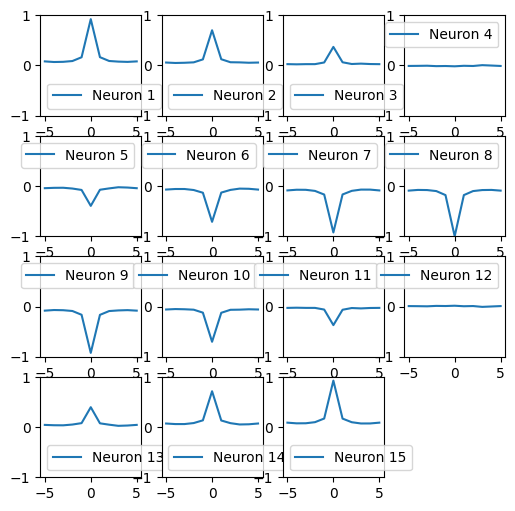

In [6]:
# plot cross correlation of neuron 1 voltage and each other neuron!!
plt.figure(figsize=(6,6))

for i in range(1,N):
    plt.subplot(4,4,i)
    # plt.plot(np.correlate(V[0,beg:end],V[i,beg:end],'full'),label=f'Neuron {i}')
    plt.xcorr(V[0],V[i],maxlags=5,label=f'Neuron {i}',usevlines=False,detrend=lambda x: x-np.mean(x),linestyle = '-',marker='')
    plt.ylim([-1,1])
    plt.legend()
    # plt.show()

# Slow vs fast correlations

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# initialize parameters and variables
np.random.seed(0)
dt = 0.001
radius = 4
nt=20000
K = 2

r_real = np.zeros([K,nt])
rs = np.zeros([K,nt])

ang=0
r_real[:,0] = r_real[:,1]=r_real[:,2]= np.array([radius*np.cos(ang),radius*np.sin(ang)])

In [26]:
N = 16
lam = 4

# D = np.random.randn(N,K) 
# D = D / np.linalg.norm(D,axis=0)
# have 6 vectors in 2D, each pointing to different hours
D = np.array([[np.sin(2*np.pi/N*i),np.cos(2*np.pi/N*i)] for i in range(N)])/4
# plot D as arrows in 2D space
T = np.diag(D @ D.T) /2

V = np.zeros([N,nt])
V[:,0] = 0.95*T

sigma = np.zeros([N,nt])

r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

In [27]:
Nr = 2000
beta = np.random.randn(int(Nr/2),1)*10
beta = np.concatenate([beta,-beta]) 

np.random.seed(0)
ang_vel=np.concatenate([[np.random.rand()+1]*1000 + [0]*1000 for _ in range(int((nt+1)/2000))])*0.005
# ang_vel = ndimage.gaussian_filter1d(ang_vel,100,axis=0)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

In [28]:
alpha

196.2565251770015

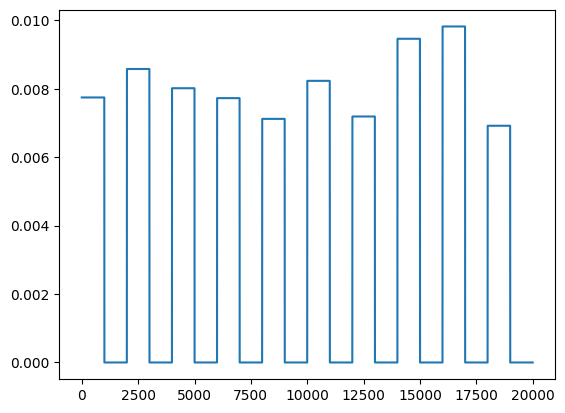

In [29]:
plt.plot(ang_vel)

In [30]:
O_f = - D @ D.T
O_s = lam * D @ D.T

def DU_xy(s_t,r_new,r_old):
    observation =  -(beta.T@(s_t.T - 1)).T/alpha  * np.flip(D.T @ r_old) * [1,-1]
    ring = - 4 * (D.T @ r_new) * ( r_new @ D @ D.T @ r_new.T - radius**2)
    return  observation + ring

In [31]:
for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

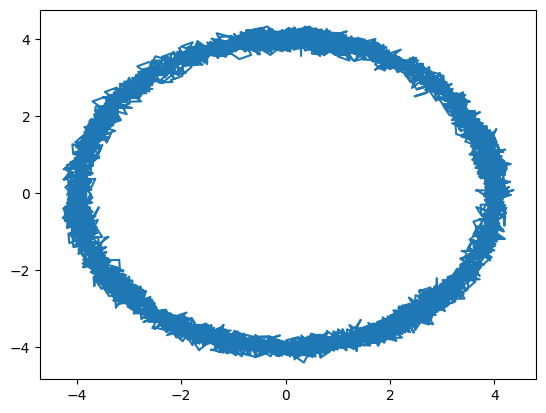

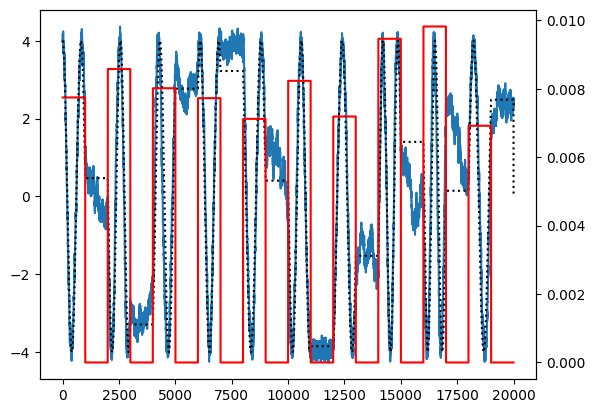

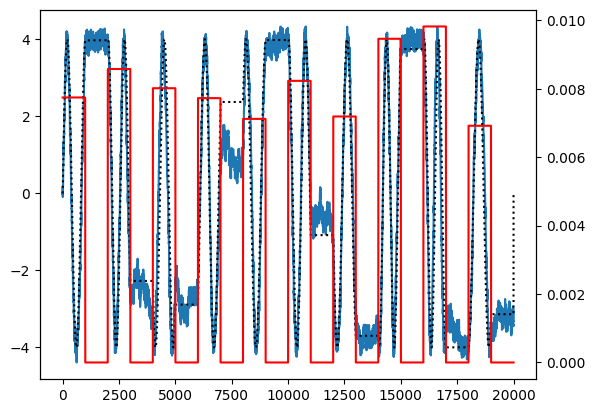

In [32]:
# sanity check
plt.plot(xs,ys)
plt.show()

plt.plot(xs)
plt.plot(r_real[0],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

plt.plot(ys)
plt.plot(r_real[1],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

In [33]:
# % - B: fast vs slow interactions, and short time vs long time correlations (short time correlations can be at one time step delay - they should look very much like the connectivity matrix!)
sigma.shape

(16, 20000)

In [34]:
from scipy import ndimage as nd

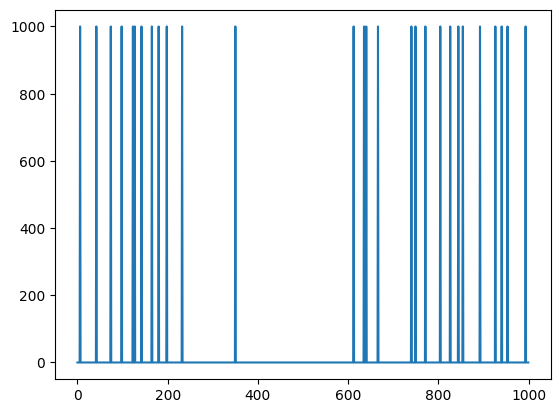

In [35]:
plt.plot(nd.gaussian_filter1d(sigma,0.1,axis=1)[0][:1000])

In [36]:
def mask_lower_diag(M):
    # cover lower diagonal with nans
    MM = np.copy(M)
    MM[np.tril_indices(M.shape[0], k=0)] = np.nan
    return MM

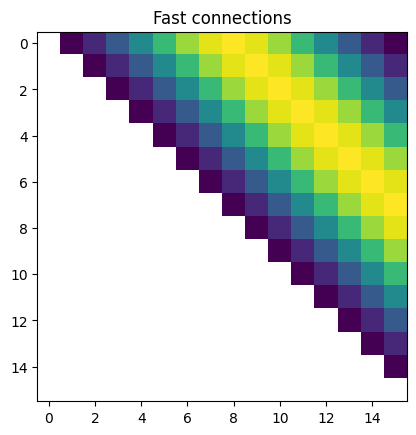

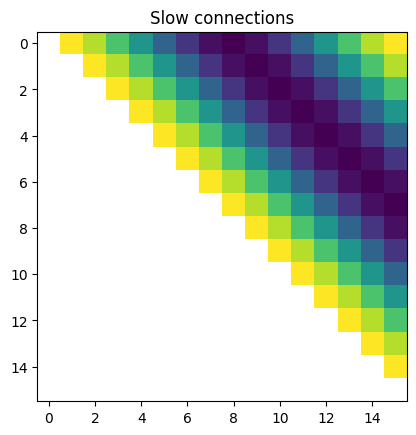

In [37]:
# connectivity matrix
O_f = - D @ D.T
O_s = lam * D @ D.T
# plot it
plt.imshow(mask_lower_diag(O_f))
plt.title('Fast connections')
plt.show()
plt.imshow(mask_lower_diag(O_s))
plt.title('Slow connections')
plt.show()

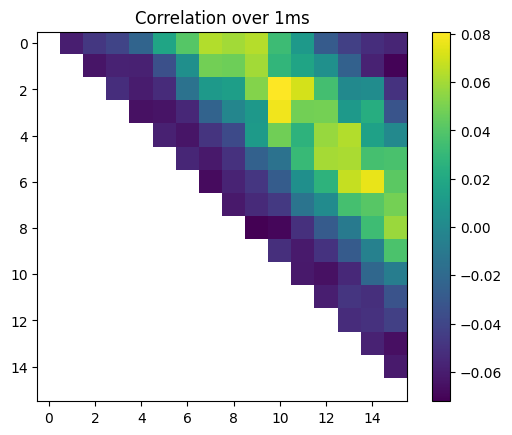

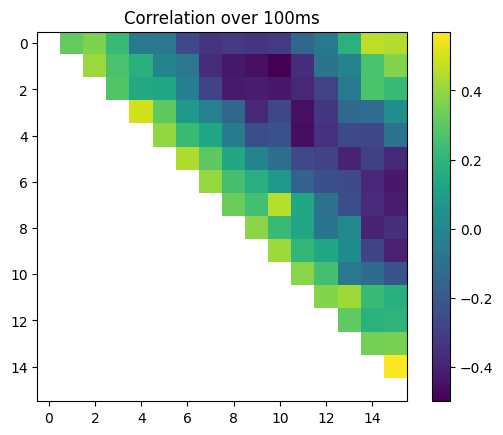

In [38]:
# short and long time correlations
for i in [1,100]:
    plt.figure()
    plt.imshow(mask_lower_diag(np.corrcoef(nd.gaussian_filter1d(sigma,i,axis=1))))
    plt.colorbar()
    plt.title('Correlation over ' + str(i) + 'ms')
    plt.show()

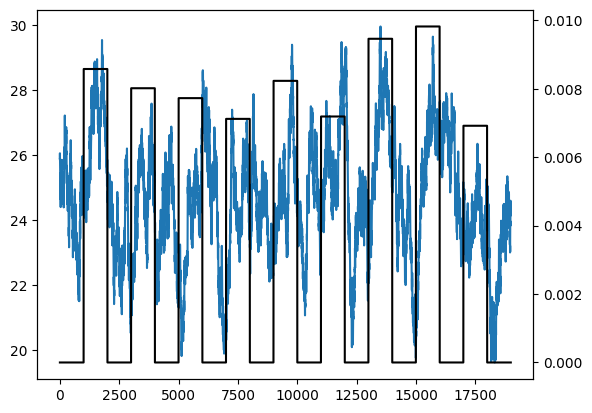

In [39]:
# plot overall activity vs angular velocity

# plt.plot(nd.gaussian_filter1d(np.linalg.norm(r,axis=0)[1000:],10))
plt.plot(np.linalg.norm(r,axis=0)[1000:])
plt.twinx()
plt.plot(ang_vel[1000:],'k')

# bump movement diff

In [ ]:
# initialize parameters and variables
np.random.seed(0)
dt = 0.001
radius = 4
nt=100000
K = 2

r_real = np.zeros([K,nt])
rs = np.zeros([K,nt])

ang=0.
r_real[:,0] = r_real[:,1]=r_real[:,2]= np.array([radius*np.cos(ang),radius*np.sin(ang)])

N=200
lam = 1

D = np.array([[np.sin(2*np.pi/N*i),np.cos(2*np.pi/N*i)] for i in range(N)])/20
T = np.diag(D @ D.T) /2

# interactions
O_f = - D @ D.T
O_s = lam * D @ D.T

def DU_xy(s_t,r_new,r_old):
    observation =  -(beta.T@(s_t.T - 1)).T/alpha  * np.flip(D.T @ r_old) * [1,-1]
    ring = - 4 * (D.T @ r_new) * ( r_new @ D @ D.T @ r_new.T - radius**2)
    return  observation + ring
Nr = 1000
beta = np.random.randn(int(Nr/2),1)*5
beta = np.concatenate([beta,-beta]) 

np.random.seed(0)
ang_vel = np.linspace(-0.01,0.01,nt)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]
V = np.zeros([N,nt])
V[:,0] = 0.95*T
sigma = np.zeros([N,nt])
r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.argmax(V[above,t+1])], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

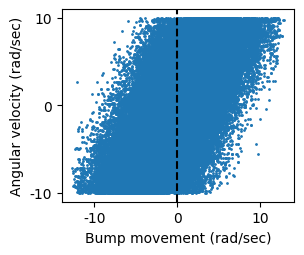

In [ ]:
# scatter plot bump movement vs angular velocity
plt.figure(figsize=(3,2.5))
bump_mov = np.unwrap(np.arctan2(ys,xs))
bump_mov = bump_mov[5:] - bump_mov[:-5]
plt.scatter(bump_mov, ang_vel[5:],s=1,rasterized=True)
plt.yticks([-0.01,0,0.01],[-10,0,10])
plt.xticks([-0.1,0,0.1],[-10,0,10])
plt.ylabel('Angular velocity (rad/sec)')
plt.xlabel('Bump movement (rad/sec)')
# plt.ylabel('Angular velocity')
plt.axvline(0,c='k',ls='--')
# plt.axhline(0,c='k',ls='--')
# plt.savefig('bump_vs_angvel.pdf',dpi=300)

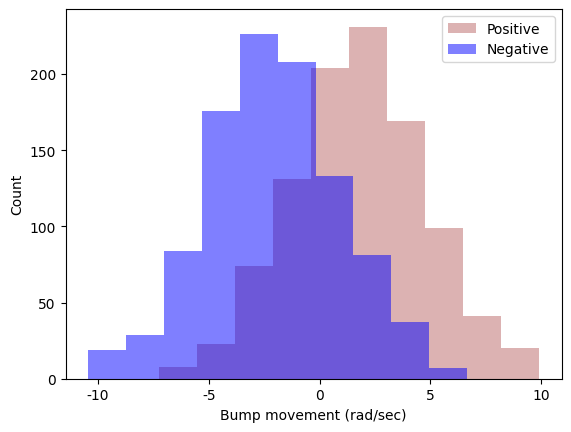

In [ ]:
min = 0.0039
max = 0.0041
# plt.hist(bump_mov[(ang_vel[5:]>min)*(ang_vel[5:]<max)],bins=np.arange(-0.1,0.11,0.025),alpha=0.3,color='darkred',label='Positive')
plt.hist(bump_mov[(ang_vel[5:]>min)*(ang_vel[5:]<max)],bins=10,alpha=0.3,color='darkred',label='Positive')
# plt.hist(bump_mov[(ang_vel[5:]<-min)*(ang_vel[5:]>-max)],bins=np.arange(-0.1,0.11,0.025),alpha=0.5,color='b',label='Negative')
plt.hist(bump_mov[(ang_vel[5:]<-min)*(ang_vel[5:]>-max)],bins=10,alpha=0.5,color='b',label='Negative')
plt.legend()
plt.xticks(np.arange(-0.1,0.11,0.05),np.arange(-10,11,5))
plt.ylabel('Count')
plt.xlabel('Bump movement (rad/sec)')
plt.savefig('bump_vs_angvel_hist.pdf',dpi=300)

# fast vs slow leak

In [10]:
lam

10

In [17]:
# use a smaller lambda (slow decay)
lam=1

In [18]:
V = np.zeros([N,nt])
V[:,0] = 0.95*T
sigma = np.zeros([N,nt])
r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt
        # sigma[above[0], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

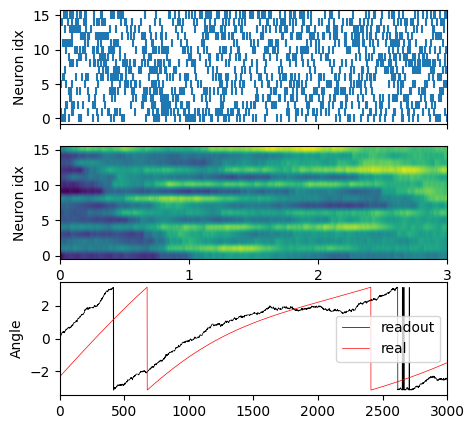

In [23]:
beg,end = 1000,4000

plt.figure(figsize=(5,5))

plt.subplot(313)

# plot readout
plt.plot(np.arctan2(ys[beg:end],xs[beg:end]),'k',lw=0.5,label='readout')
# plot real
plt.plot(np.arctan2(r_real[1,beg:end],r_real[0,beg:end]),'r',lw=0.5,label='real')
plt.legend()
plt.ylabel('Angle')

# plot voltave traces, one on each line, from beg to end
# for iv,v in enumerate(V):
#     plt.plot(v[beg:end] + iv*0.12,color='darkgreen',alpha=0.5,lw=0.3)
# plt.xticks(np.arange(0,end-beg+1000,1000),[])

plt.xlim(0,end-beg)

# plot sigma as in putting a small dot wherewer a spike occurs
plt.subplot(311)
x,y = np.where(sigma[:,beg:end])
plt.scatter(y,x,marker='|',rasterized=True)
plt.xticks(np.arange(0,end-beg+1000,1000),[])
plt.xlim(0,end-beg)
plt.ylabel('Neuron idx')

plt.subplot(312)
plt.imshow(r[:,beg:end],aspect='auto',origin='lower')
plt.xticks(np.arange(0,end-beg+1000,1000),np.arange(int((end-beg)/1000)+1))
plt.ylabel('Neuron idx')

plt.show()

# losing true orientation as a function of input noise

In [ ]:
# Messy -- please clean up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as nd

# initialize parameters and variables
np.random.seed(12345)
dt = 0.001
radius = 5
nt=20000
K = 2

r_real = np.zeros([K,nt])
rs = np.zeros([K,nt])

ang=0
r_real[:,0] = r_real[:,1]=r_real[:,2]= np.array([radius*np.cos(ang),radius*np.sin(ang)])

In [ ]:
N = 50
lam = 2

D = np.random.randn(N,K) 
D = D / np.linalg.norm(D,axis=0)
T = np.diag(D @ D.T) /2

V = np.zeros([N,nt])
V[:,0] = 0.95*T

sigma = np.zeros([N,nt])

r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

In [ ]:
Nr = 5000
beta = np.random.randn(int(Nr/2),1)*10
beta = np.concatenate([beta,-beta]) 

np.random.seed(0)
ang_vel=np.concatenate([[np.random.rand()+1]*1000 + [0]*1000 for _ in range(int((nt+1)/2000))])*0.005
# ang_vel = np.ones(nt)*0.005
# ang_vel = ndimage.gaussian_filter1d(ang_vel,100,axis=0)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

Text(0, 0.5, 'angular velocity')

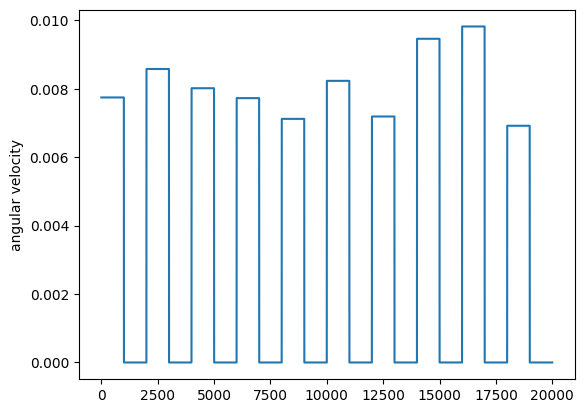

In [ ]:
plt.plot(ang_vel)
plt.ylabel('angular velocity')

\begin{align*}
& \nabla_{\theta_t} \log P(\theta_t|\mathbf{s_t},\theta_{t-1}) = \nabla_{x_t,y_t} \log P(x_t,y_t|\mathbf{s_t},x_{t-1},y_{t-1})  \\ 
&=  \underbrace{\begin{bmatrix}
        y_{t-1} \\
        -x_{t-1}
    \end{bmatrix}
    \Beta \Big( \mathbf{s_t} - 1 \Big)}_{\text{update}}
    - 4
    \underbrace{
    \begin{bmatrix}
        x_t^3 + x_t y_t^2 - x_t r^2  \\
        y_t^3 + y_t x_t^2 - y_t r^2  
    \end{bmatrix} }_{\text{ring attractor}}
    - \underbrace{2 \gamma
    \begin{bmatrix}
        (x_t - x_{t-1})  \\
        (y_t - y_{t-1}) 
    \end{bmatrix}}_{\text{continuity}}
\end{align*}

In [ ]:
O_f = - D @ D.T
O_s = lam * D @ D.T

def DU_xy(s_t,r_new,r_old):
    observation =  -(beta.T@(s_t.T - 1)).T/alpha  * np.flip(D.T @ r_old) * [1,-1]
    ring = - 4 * (D.T @ r_new) * ( r_new @ D @ D.T @ r_new.T - radius**2)
    return  observation + ring

In [ ]:
for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t+1] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

In [ ]:
D.T@r[:,0]

array([ 5.00000000e+00, -7.25114413e-16])

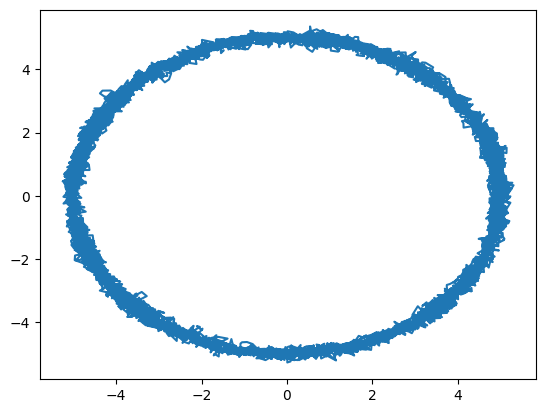

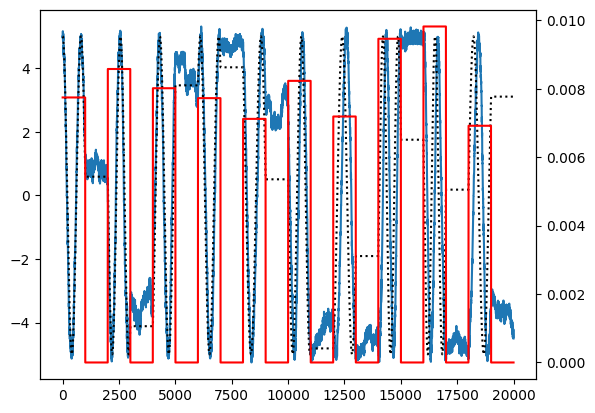

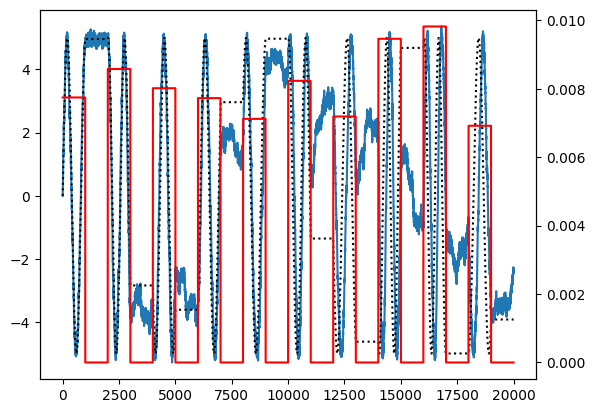

In [ ]:
plt.plot(xs,ys)
plt.show()

plt.plot(xs)
plt.plot(r_real[0],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

plt.plot(ys)
plt.plot(r_real[1],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

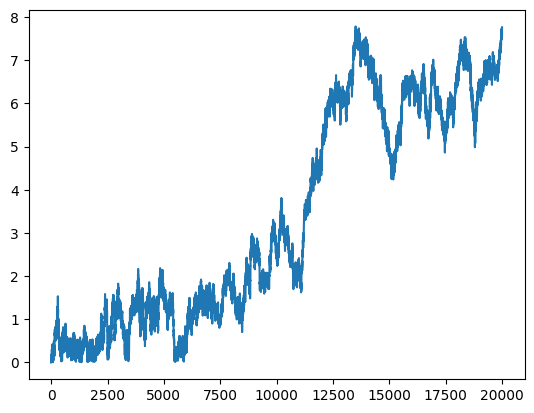

In [ ]:
# plot the l2 norm of the difference between the real and estimated values
plt.plot(np.linalg.norm(r_real - x_y_est,axis=0))

In [ ]:
# get the angle encoded by the network
angle_est = np.arctan2(xs,ys)
angle_real = np.arctan2(r_real[0],r_real[1])

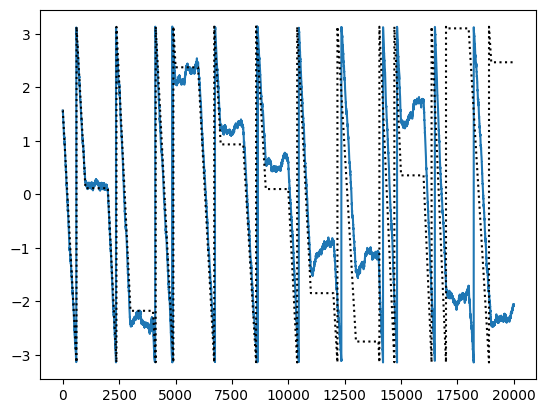

In [ ]:
# plot the two
plt.plot(angle_est)
plt.plot(angle_real,'k',ls='dotted')

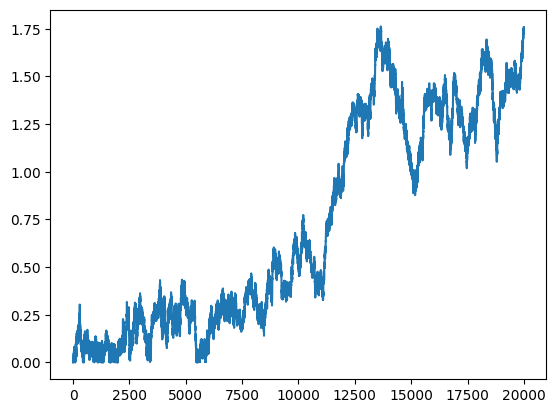

In [ ]:
# plot the abs angle difference
plt.plot(np.abs(np.arctan2(np.sin(angle_est - angle_real),np.cos(angle_est - angle_real))))

In [ ]:
N

50

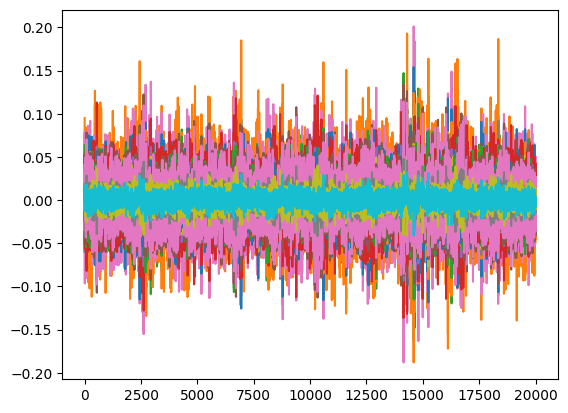

In [ ]:
# plot V, spikes sigma, r, and readout
plt.plot(V.T)
# plt.plot(sigma.T)
# plt.plot(r.T)
# plt.plot(x_y_est.T)
plt.show()

0

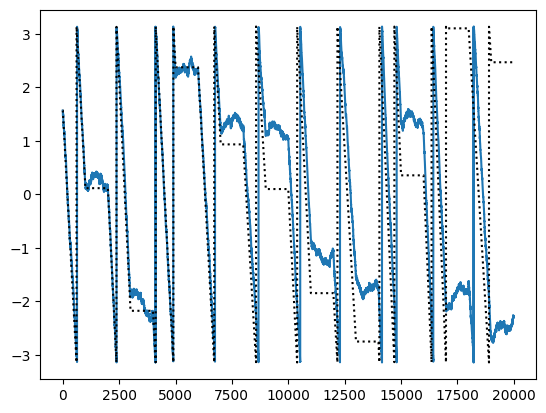

1234567891011121314151617181920

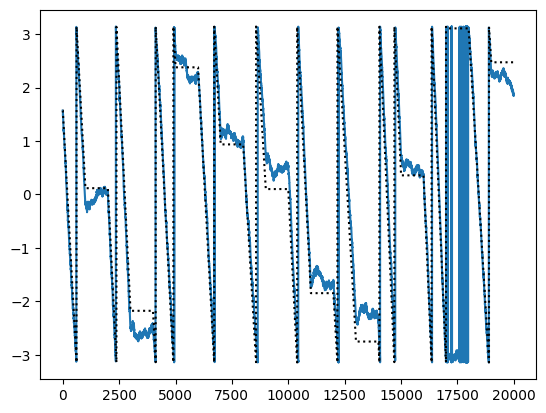

2122232425262728293031323334353637383940

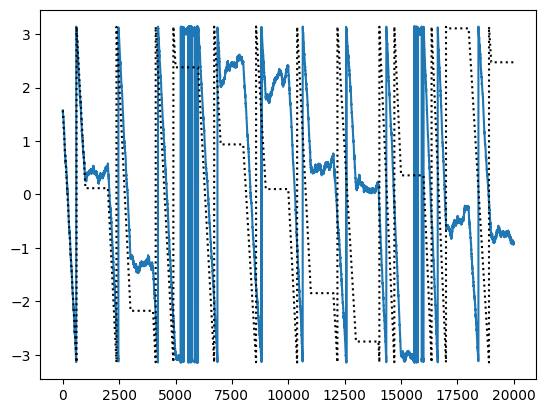

414243444546474849

In [ ]:
# run the network 50 times and average the results
ang_diffs = []
for _ in range(50):
    print(_,end='')
    V = np.zeros([N,nt])
    V[:,0] = 0.95*T

    sigma = np.zeros([N,nt])

    r = np.zeros([N,nt])
    r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

    for t in range(2,nt-1):
        
        V[:, t + 1] = V[:, t] + dt * (
            - lam * V[:, t]
            + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
            + O_s @ r[:, t]
            + O_f @ sigma[:, t]
        ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

        above = np.where(V[:, t + 1] > T)[0]

        if len(above):
            sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt

        r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

    x_y_est = D.T @ r
    xs = x_y_est[0,:]
    ys = x_y_est[1,:]
    # get the angle encoded by the network
    angle_est = np.arctan2(xs,ys)
    
    # sanity check
    if np.mod(_,20)==0:
        # plot the two
        plt.plot(angle_est)
        plt.plot(angle_real,'k',ls='dotted')
        plt.show()
    ang_diffs.append(np.abs(np.arctan2(np.sin(angle_est - angle_real),np.cos(angle_est - angle_real))))


(0.0, 2.05)

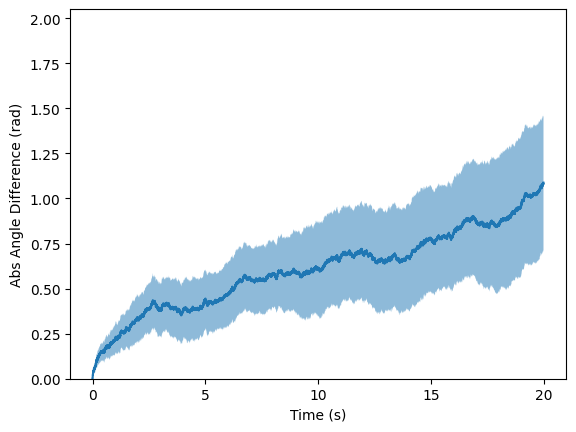

In [ ]:
# plot the abs angle difference avg and shaded std
plt.plot(np.mean(ang_diffs,axis=0)[:-1])
plt.fill_between(range(nt),np.mean(ang_diffs,axis=0)-np.std(ang_diffs,axis=0)/2,np.mean(ang_diffs,axis=0)+np.std(ang_diffs,axis=0)/2,alpha=0.5)
plt.xticks([0,5000,10000,15000,20000],['0','5','10','15','20'])
plt.xlabel('Time (s)')
plt.ylabel('Abs Angle Difference (rad)')
plt.ylim([0,2.05])

In [ ]:
# same as above, with fewer and noisier input neurons
Nr = 1000
beta = np.random.randn(int(Nr/2),1)*5
beta = np.concatenate([beta,-beta]) 
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

In [ ]:
for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t+1] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xs = x_y_est[0,:]
ys = x_y_est[1,:]

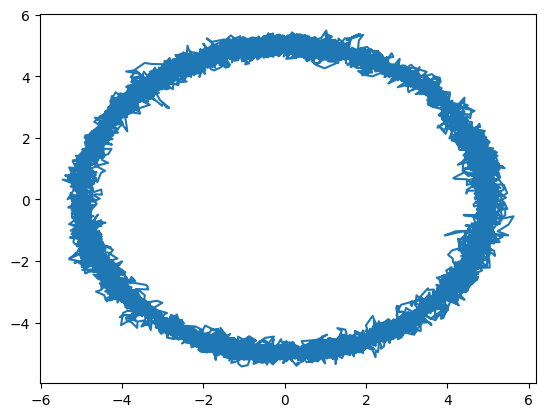

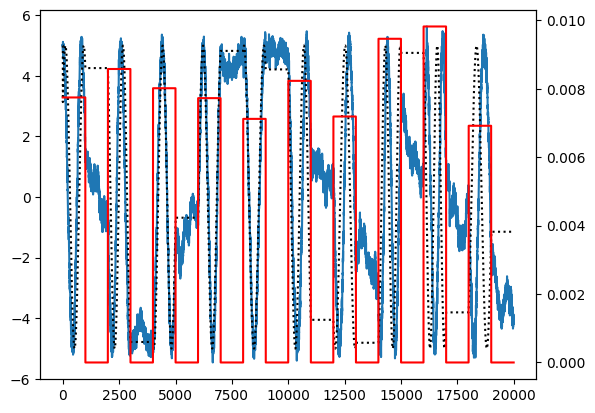

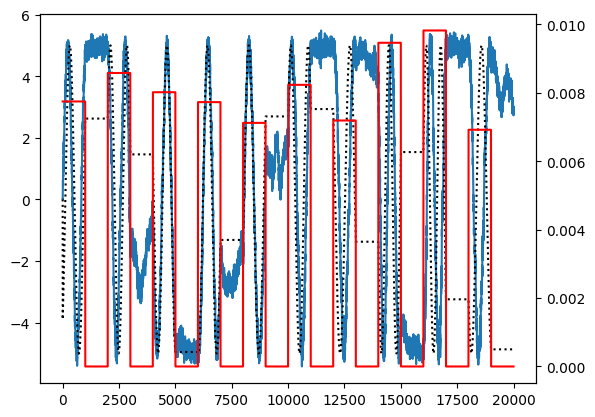

In [ ]:
plt.plot(xs,ys)
plt.show()

plt.plot(xs)
plt.plot(r_real[0],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

plt.plot(ys)
plt.plot(r_real[1],'k',ls='dotted')
plt.twinx()
plt.plot(ang_vel, 'r')
plt.show()

0

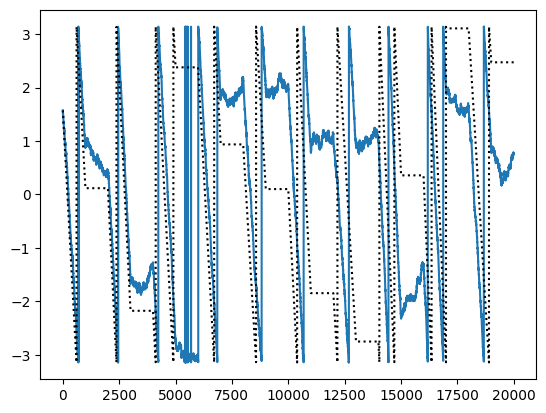

1234567891011121314151617181920

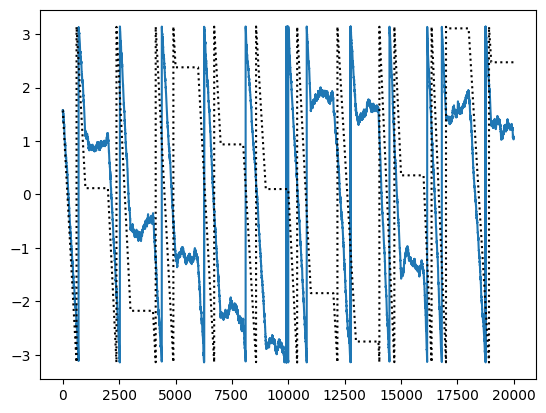

2122232425262728293031323334353637383940

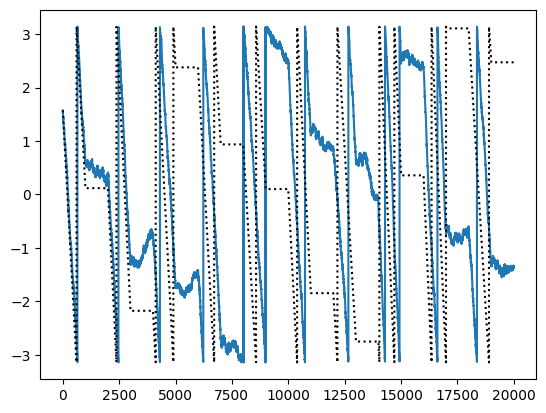

414243444546474849

In [ ]:
# run the network 100 times and average the results
ang_diffs = []
for _ in range(50):
    print(_,end='')
    V = np.zeros([N,nt])
    V[:,0] = 0.95*T

    sigma = np.zeros([N,nt])

    r = np.zeros([N,nt])
    r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

    for t in range(2,nt-1):
        
        V[:, t + 1] = V[:, t] + dt * (
            - lam * V[:, t]
            + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
            + O_s @ r[:, t]
            + O_f @ sigma[:, t]
        ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

        above = np.where(V[:, t + 1] > T)[0]

        if len(above):
            sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt

        r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

    x_y_est = D.T @ r
    xs = x_y_est[0,:]
    ys = x_y_est[1,:]
    # get the angle encoded by the network
    angle_est = np.arctan2(xs,ys)
    
    # sanity check
    if np.mod(_,20)==0:
        # plot the two
        plt.plot(angle_est)
        plt.plot(angle_real,'k',ls='dotted')
        plt.show()
    ang_diffs.append(np.abs(np.arctan2(np.sin(angle_est - angle_real),np.cos(angle_est - angle_real))))


(0.0, 2.05)

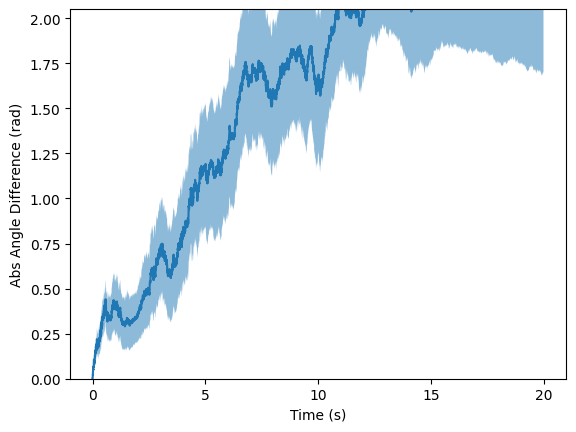

In [ ]:
# plot the abs angle difference avg and shaded std
plt.plot(np.mean(ang_diffs,axis=0)[:-1])
plt.fill_between(range(nt),np.mean(ang_diffs,axis=0)-np.std(ang_diffs,axis=0)/2,np.mean(ang_diffs,axis=0)+np.std(ang_diffs,axis=0)/2,alpha=0.5)
plt.xticks([0,5000,10000,15000,20000],['0','5','10','15','20'])
plt.xlabel('Time (s)')
plt.ylabel('Abs Angle Difference (rad)')
plt.ylim([0,2.05])

# absence of attractor

In [ ]:
# initialize parameters and variables
# np.random.seed(0)
dt = 0.001
radius = 4
nt=20000
K = 2

r_real = np.zeros([K,nt])
rs = np.zeros([K,nt])

ang=0
r_real[:,0] = r_real[:,1]=r_real[:,2]= np.array([radius*np.cos(ang),radius*np.sin(ang)])

In [ ]:
N = 8
lam = 10

D = np.array([[np.sin(2*np.pi/N*i),np.cos(2*np.pi/N*i)] for i in range(N)])/4
T = np.diag(D @ D.T) /2

# interactions
O_f = - D @ D.T
O_s = lam * D @ D.T

def DU_xy(s_t,r_new,r_old):
    observation =  -(beta.T@(s_t.T - 1)).T/alpha  * np.flip(D.T @ r_old) * [1,-1]
    # ring = - 4 * (D.T @ r_new) * ( r_new @ D @ D.T @ r_new.T - radius**2)
    return  observation# + ring

In [ ]:
Nr = 20
beta = np.random.randn(int(Nr/2),1)*10
beta = np.concatenate([beta,-beta]) 

np.random.seed(0)
ang_vel=np.concatenate([[np.random.randn()]*2000 for _ in range(int((nt+1)/2000))])*0.005
ang_vel = ndi.gaussian_filter1d(ang_vel,500,axis=0)
kernel = np.exp(beta @ ang_vel.reshape(1,-1))
s = np.random.poisson(kernel) 
alpha = (1 + beta.T@beta*dt)[0,0]

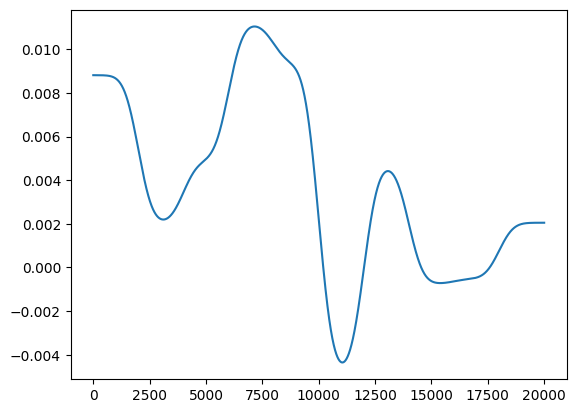

In [ ]:
plt.plot(ang_vel)

In [ ]:
V = np.zeros([N,nt])
V[:,0] = 0.95*T
sigma = np.zeros([N,nt])
r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt
        # sigma[above[0], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])

x_y_est = D.T @ r
xsl = x_y_est[0,:]
ysl = x_y_est[1,:]

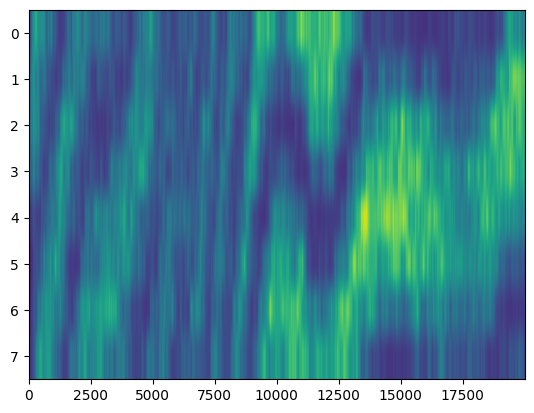

In [ ]:
plt.imshow(r,aspect='auto')

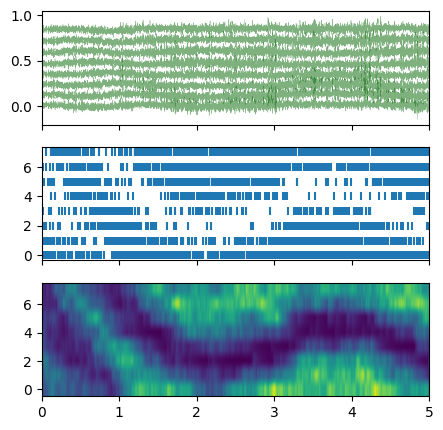

In [ ]:
beg,end = 8000,13000

plt.figure(figsize=(5,5))

plt.subplot(311)

# plot voltave traces, one on each line, from beg to end
for iv,v in enumerate(V):
    plt.plot(v[beg:end] + iv*0.12,color='darkgreen',alpha=0.5,lw=0.3)
plt.xticks(np.arange(0,end-beg+1000,1000),[])

plt.xlim(0,end-beg)

# plot sigma as in putting a small dot wherewer a spike occurs
plt.subplot(312)
x,y = np.where(sigma[:,beg:end])
plt.scatter(y,x,marker='|',rasterized=True)
plt.xticks(np.arange(0,end-beg+1000,1000),[])
plt.xlim(0,end-beg)

plt.subplot(313)
plt.imshow(r[:,beg:end],aspect='auto',origin='lower')
plt.xticks(np.arange(0,end-beg+1000,1000),np.arange(6))

# plt.savefig('donut_8neur_action.pdf',dpi=300)

plt.show()

In [ ]:
## implement hard reset
V = np.zeros([N,nt])
V[:,0] = 0.95*T
sigma = np.zeros([N,nt])
r = np.zeros([N,nt])
r[:,0] = r[:,1] = r[:,2]= np.array(np.linalg.pinv(D.T)@r_real[:,0])

for t in range(2,nt-1):
    ang += ang_vel[t-1]   
    r_real[:,t] = np.array([radius*np.cos(ang),radius*np.sin(ang)])
    
    V[:, t + 1] = V[:, t] + dt * (
        - lam * V[:, t]
        + D @ DU_xy(s[:,t-1],r[:,t-1],r[:,t-2])
        + O_s @ r[:, t]
        + O_f @ sigma[:, t]
    ) + D @ (np.random.randn(K) * np.sqrt(2 * dt))

    above = np.where(V[:, t + 1] > T)[0]

    if len(above):
        sigma[above[np.random.randint(len(above))], t + 1] = 1 / dt
        # sigma[above[0], t + 1] = 1 / dt

    r[:, t + 1] = r[:, t] + dt * (sigma[:, t + 1] - lam * r[:, t])
    # make sure that Dr has radius = radius
    r[:,t+1] = r[:,t+1]/np.linalg.norm(D.T@r[:,t+1])*radius

x_y_est = D.T @ r
xshr = x_y_est[0,:]
yshr = x_y_est[1,:]

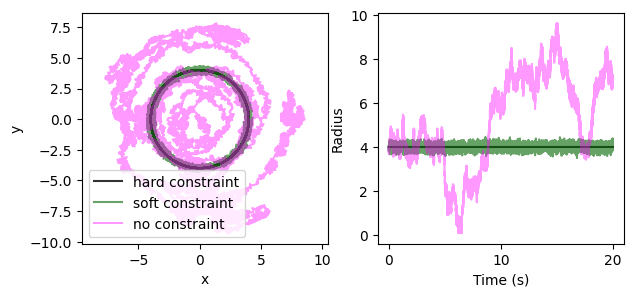

In [ ]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.plot(xshr, yshr,alpha=0.8,label='hard constraint',c='k')
plt.plot(xs,ys,alpha=0.6,label='soft constraint',c='darkgreen')
plt.axis('equal')
plt.plot(xsl,ysl,alpha=0.4,label = 'no constraint',c='magenta')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(122)
# plot radis
plt.plot(np.sqrt(xshr**2 + yshr**2),alpha=0.8,c='k')
plt.plot(np.sqrt(xs**2 + ys**2),alpha=0.6,c='darkgreen')
plt.plot(np.sqrt(xsl**2 + ysl**2),alpha=0.4,c='magenta')
# plt.axhline(radius,c='k',ls='--')
plt.xticks([0,10000,20000],[0,10,20])
plt.ylabel('Radius')
plt.xlabel('Time (s)')

plt.savefig('soft_hard_constr.pdf',dpi=300)